In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [2]:
# Import the data
folder = "GHI"
folder1 = "PR"

# Initialize an empty DataFrame to hold the merged data
data = pd.DataFrame()
data1 = pd.DataFrame()

In [3]:
for subfolder in os.listdir(folder):
    subfolder_path = os.path.join(folder, subfolder)
    if os.path.isdir(subfolder_path): 
       
        for file in os.listdir(subfolder_path):
            if file.endswith(".csv"):
                file_path = os.path.join(subfolder_path, file) 
                df = pd.read_csv(file_path)
                data = pd.concat([data, df], ignore_index=True)

In [4]:
data

,Date,GHI
0,2019-07-01,3.256608
1,2019-07-02,3.976767
2,2019-07-03,2.811867
3,2019-07-04,3.658408
4,2019-07-05,5.590683
...,...,...
977,2022-03-20,4.226183
978,2022-03-21,3.431675
979,2022-03-22,3.580492
980,2022-03-23,4.997617


In [5]:
for subfolder in os.listdir(folder1):
    subfolder_path = os.path.join(folder1, subfolder)
    if os.path.isdir(subfolder_path):
        
        for file in os.listdir(subfolder_path):
            if file.endswith(".csv"):
                file_path = os.path.join(subfolder_path, file)
                df = pd.read_csv(file_path)
                data1 = pd.concat([data1, df], ignore_index=True)

In [6]:
data1

,Date,PR
0,2019-07-01,69.575676
1,2019-07-02,79.314411
2,2019-07-03,61.020006
3,2019-07-04,83.262576
4,2019-07-05,82.124440
...,...,...
977,2022-03-20,81.632738
978,2022-03-21,71.057353
979,2022-03-22,81.631509
980,2022-03-23,71.906149


### Merging the two dataframes

In [7]:
df = pd.merge(data, data1, on='Date')
df

,Date,GHI,PR
0,2019-07-01,3.256608,69.575676
1,2019-07-02,3.976767,79.314411
2,2019-07-03,2.811867,61.020006
3,2019-07-04,3.658408,83.262576
4,2019-07-05,5.590683,82.124440
...,...,...,...
977,2022-03-20,4.226183,81.632738
978,2022-03-21,3.431675,71.057353
979,2022-03-22,3.580492,81.631509
980,2022-03-23,4.997617,71.906149


# Save dataframe to csv file

In [8]:
df.to_csv('data.csv', index=False)

# Preprocessing

In [9]:
df.shape

(982, 3)

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.isnull().sum()

Date    0
GHI     0
PR      0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    982 non-null    object 
 1   GHI     982 non-null    float64
 2   PR      982 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.1+ KB


In [13]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
GHI,982.0,4.63,1.02,1.41,4.02,4.74,5.31,6.95
PR,982.0,72.71,7.29,60.02,66.31,72.95,79.11,84.98


# Visualization

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib import colors
import pandas as pd

def plot_pr_evolution(df, start_date, end_date):
    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data based on start and end dates
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    # Calculate 30-day moving average for PR
    df['PR_MA'] = df['PR'].rolling(window=30).mean()
    
    # Create GHI bins for coloring
    df['GHI_bin'] = pd.cut(df['GHI'], bins=[-float('inf'), 2, 4, 6, float('inf')], labels=['<2', '2-4', '4-6', '>6'])
    
    # Define colors based on GHI bins
    color_map = {
        '<2': 'navy',
        '2-4': 'lightblue',
        '4-6': 'orange',
        '>6': 'brown'
    }
    
    # Create a list of patches
    patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
    
    # Calculate the dynamic budget line
    start_year = pd.to_datetime('2019-07-01').year
    df['Budget_PR'] = 73.9 - ((df['Date'].dt.year - start_year) * 0.6)

    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Plot scatter points with colors based on GHI
    plt.scatter(df['Date'], df['PR'], c=df['GHI_bin'].map(color_map), alpha=0.7, label=color_map, marker='D')
    
    # Plot the 30-day moving average line
    plt.plot(df['Date'], df['PR_MA'], color='red', label='30-d moving average of PR', linewidth=2)
    
    # Plot the Budget PR line
    plt.plot(df['Date'], df['Budget_PR'], color='green', label='Target Budget Yield Performance Ratio', linewidth=2)
    
    # Format the date on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b/%y"))
    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

    # Set the Y-axis limits and ticks
    plt.yticks(range(0, 101, 10))
    
    # Calculate percentage of points above Budget PR
    percentage_above_budget = (df['PR'] > df['Budget_PR']).sum() / len(df) * 100
    plt.text(pd.to_datetime('2020-01-01'), 50, f'-- Target Budget Yield Performance Ratio [1Y-73.9%,2Y-73.3%,3Y-72.7%', fontsize=12, color='green')
    plt.text(pd.to_datetime('2020-01-01'), 45, f'-- 30-d moving average of PR', fontsize=12, color='red')
    plt.text(pd.to_datetime('2020-01-01'), 40, f'Points above Target Budget PR = {percentage_above_budget:.1f}%', fontsize=12, fontweight='bold')
    
    # Annotations for average PR values
    average_pr_values = {
        'last 7-d': df['PR'][-7:].mean(),
        'last 30-d': df['PR'][-30:].mean(),
        'last 60-d': df['PR'][-60:].mean(),
        'last 90-d': df['PR'][-90:].mean(),
        'last 365-d': df['PR'][-365:].mean(),
        'Lifetime': df['PR'].mean()
    }
    
    text_str = "\n".join([f"Average PR {period}: {value:.1f} %" for period, value in average_pr_values.items()])
    plt.text(pd.to_datetime('2021-08-01'), 10, text_str, fontsize=12)
    plt.title('Performance Ratio Evolution\nFrom {} to {}'.format(start_date, end_date), fontweight='bold')
    plt.ylabel('Performance Ratio[%]')
    plt.legend(handles=patches, title="Dialy Irradiation [kWh/m2]", loc='upper left', ncol=4)
    plt.grid(True)
    plt.show()


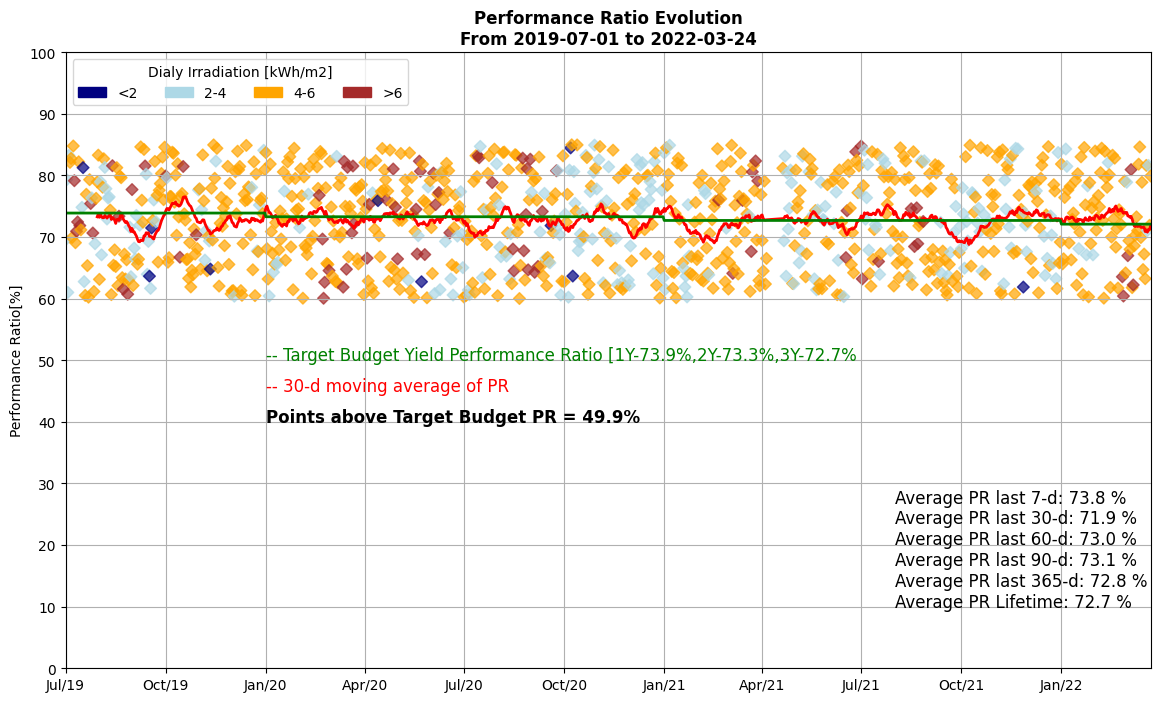

In [15]:
# Example usage
start_date = '2019-07-01'
end_date = '2022-03-24'
plot_pr_evolution(df, start_date, end_date)